# Water Quality Classification Project

This notebook implements a machine learning pipeline for classifying water quality based on various parameters. The classification follows the Central Pollution Control Board (CPCB) standards for Water Quality Index (WQI).

## 1. Imports

In [29]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# XGBoost (try-except in case it's not available)
try:
    import xgboost as xgb
    from xgboost import XGBClassifier
    xgboost_available = True
except ImportError:
    xgboost_available = False
    print("XGBoost not available. Will use GradientBoostingClassifier instead.")

# SMOTE for handling imbalanced data
from imblearn.over_sampling import SMOTE

# SHAP for model interpretability (optional)
try:
    import shap
    shap_available = True
except ImportError:
    shap_available = False
    print("SHAP not available. Will skip SHAP explanations.")

# For saving models
import pickle

# Set random state for reproducibility
RANDOM_STATE = 42

# Configure visualizations
plt.style.use('seaborn-v0_8-whitegrid')
sns.set(font_scale=1.2)
plt.rcParams['figure.figsize'] = (12, 8)

## 2. Load and Inspect Data

In [30]:
# Load the dataset
df = pd.read_csv('water_quality_with_final_wqi.csv')

# Display the first few rows
print("Dataset Preview:")
df.head()

Dataset Preview:


,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Water_Quality_Index
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,23
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,23
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,43
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,48
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,48


In [31]:
# Get information about the dataset
print("Dataset Information:")
df.info()

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ph                   2785 non-null   float64
 1   Hardness             3276 non-null   float64
 2   Solids               3276 non-null   float64
 3   Chloramines          3276 non-null   float64
 4   Sulfate              2495 non-null   float64
 5   Conductivity         3276 non-null   float64
 6   Organic_carbon       3276 non-null   float64
 7   Trihalomethanes      3114 non-null   float64
 8   Turbidity            3276 non-null   float64
 9   Water_Quality_Index  3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


In [32]:
# Statistical summary
print("Statistical Summary:")
df.describe()

Statistical Summary:


,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Water_Quality_Index
count,2785.000000,3276.000000,3276.000000,3276.000000,2495.000000,3276.000000,3276.000000,3114.000000,3276.000000,3276.000000
mean,7.080795,196.369496,22014.092526,7.122277,333.775777,426.205111,14.284970,66.396293,3.966786,39.520147
std,1.594320,32.879761,8768.570828,1.583085,41.416840,80.824064,3.308162,16.175008,0.780382,10.034744
min,0.000000,47.432000,320.942611,0.352000,129.000000,181.483754,2.200000,0.738000,1.450000,13.000000
25%,6.093092,176.850538,15666.690297,6.127421,307.699498,365.734414,12.065801,55.844536,3.439711,33.000000
50%,7.036752,196.967627,20927.833607,7.130299,333.073546,421.884968,14.218338,66.622485,3.955028,38.000000
75%,8.062066,216.667456,27332.762127,8.114887,359.950170,481.792304,16.557652,77.337473,4.500320,48.000000
max,14.000000,323.124000,61227.196008,13.127000,481.030642,753.342620,28.300000,124.000000,6.739000,68.000000


WQI column identified as: Water_Quality_Index


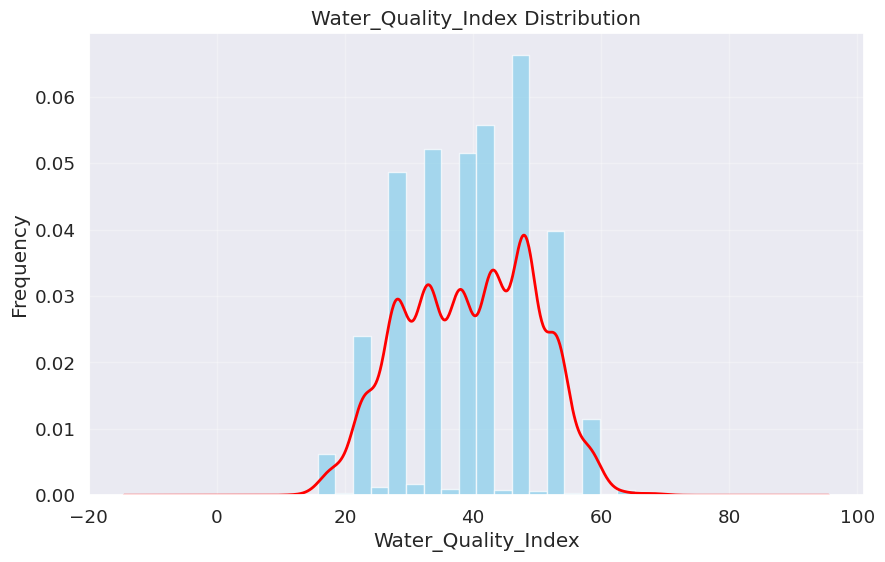

In [33]:
# Auto-detect WQI column if named differently
wqi_column = None
possible_wqi_columns = ['WQI', 'Water_Quality_Index', 'water_quality_index', 'wqi']

for col in possible_wqi_columns:
    if col in df.columns:
        wqi_column = col
        break

if wqi_column is None:
    raise ValueError("Could not find WQI column in the dataset")
else:
    print(f"WQI column identified as: {wqi_column}")

# Plot WQI distribution
plt.figure(figsize=(10, 6))
df[wqi_column].hist(bins=20, density=True, alpha=0.7, color='skyblue')
df[wqi_column].plot(kind='kde', color='red', linewidth=2)
plt.title(f'{wqi_column} Distribution')
plt.xlabel(wqi_column)
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()

## 3. Data Cleaning

In [34]:
# Check for duplicates
duplicate_count = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count}")

# Drop duplicates if any
if duplicate_count > 0:
    df = df.drop_duplicates()
    print(f"Dropped {duplicate_count} duplicate rows.")

Number of duplicate rows: 0


In [35]:
# Check for missing values
missing_values = df.isnull().sum()
print("Missing values per column:")
print(missing_values)

# Calculate percentage of missing values
missing_percentage = (missing_values / len(df)) * 100
print("\nPercentage of missing values per column:")
print(missing_percentage)

Missing values per column:
ph                     491
Hardness                 0
Solids                   0
Chloramines              0
Sulfate                781
Conductivity             0
Organic_carbon           0
Trihalomethanes        162
Turbidity                0
Water_Quality_Index      0
dtype: int64

Percentage of missing values per column:
ph                     14.987790
Hardness                0.000000
Solids                  0.000000
Chloramines             0.000000
Sulfate                23.840049
Conductivity            0.000000
Organic_carbon          0.000000
Trihalomethanes         4.945055
Turbidity               0.000000
Water_Quality_Index     0.000000
dtype: float64


In [36]:
# Impute missing values with median for numeric columns
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns

print("Imputing missing values with median for numeric columns...")
for col in numeric_columns:
    if df[col].isnull().sum() > 0:
        median_value = df[col].median()
        df[col].fillna(median_value, inplace=True)
        print(f"  - Imputed {col} with median value: {median_value:.4f}")

# Check if there are any remaining missing values
remaining_missing = df.isnull().sum().sum()
print(f"\nRemaining missing values after imputation: {remaining_missing}")

Imputing missing values with median for numeric columns...
  - Imputed ph with median value: 7.0368
  - Imputed Sulfate with median value: 333.0735
  - Imputed Trihalomethanes with median value: 66.6225

Remaining missing values after imputation: 0


/tmp/ipython-input-1200477687.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(median_value, inplace=True)


In [37]:
# Check for categorical columns and encode them if any
categorical_columns = df.select_dtypes(include=['object']).columns
print(f"Categorical columns: {list(categorical_columns)}")

# Initialize a dictionary to store label encoders
label_encoders = {}

# Encode categorical columns if any
for col in categorical_columns:
    if col != wqi_column:  # Skip WQI column if it's categorical
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le
        print(f"Encoded {col} with LabelEncoder. Classes: {list(le.classes_)}")

Categorical columns: []


Column ph: 142 outliers detected (4.33%)
  - Lower bound: 3.8891, Upper bound: 10.2586


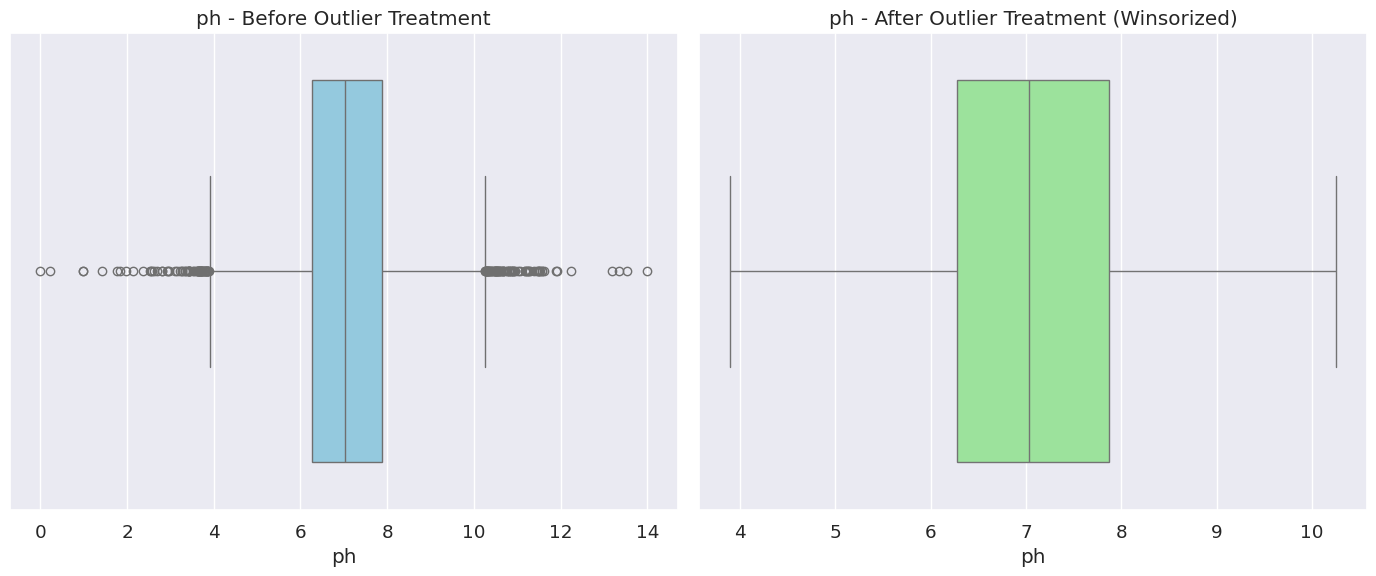

Column Hardness: 83 outliers detected (2.53%)
  - Lower bound: 117.1252, Upper bound: 276.3928


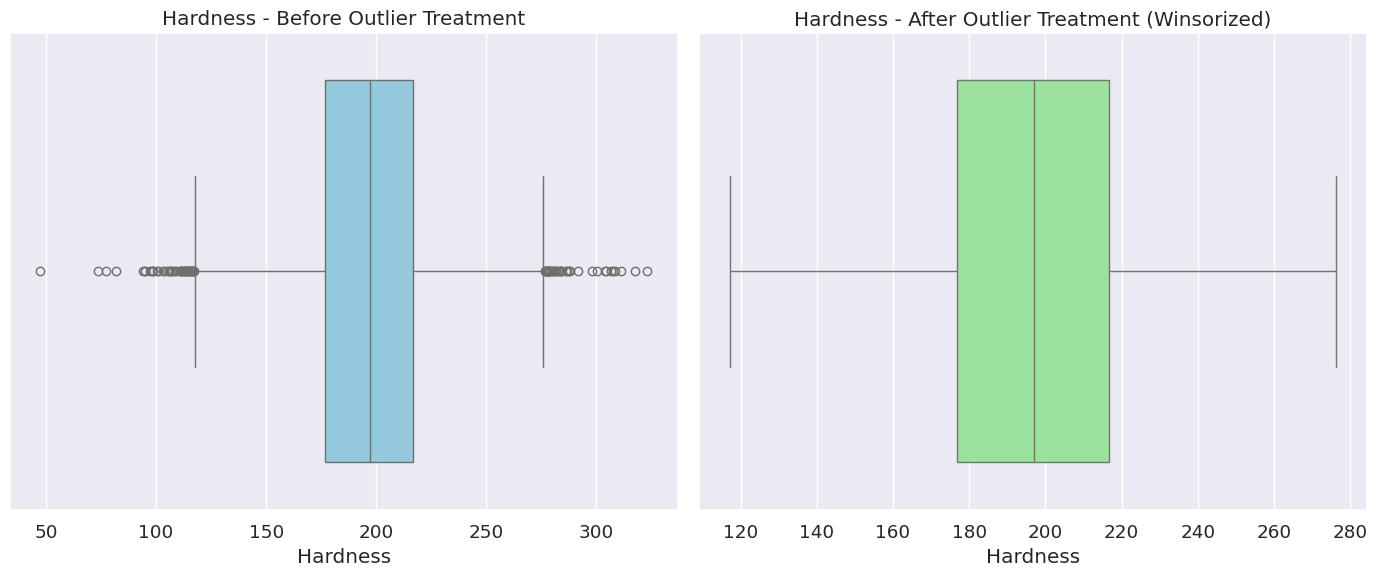

Column Solids: 47 outliers detected (1.43%)
  - Lower bound: -1832.4174, Upper bound: 44831.8699


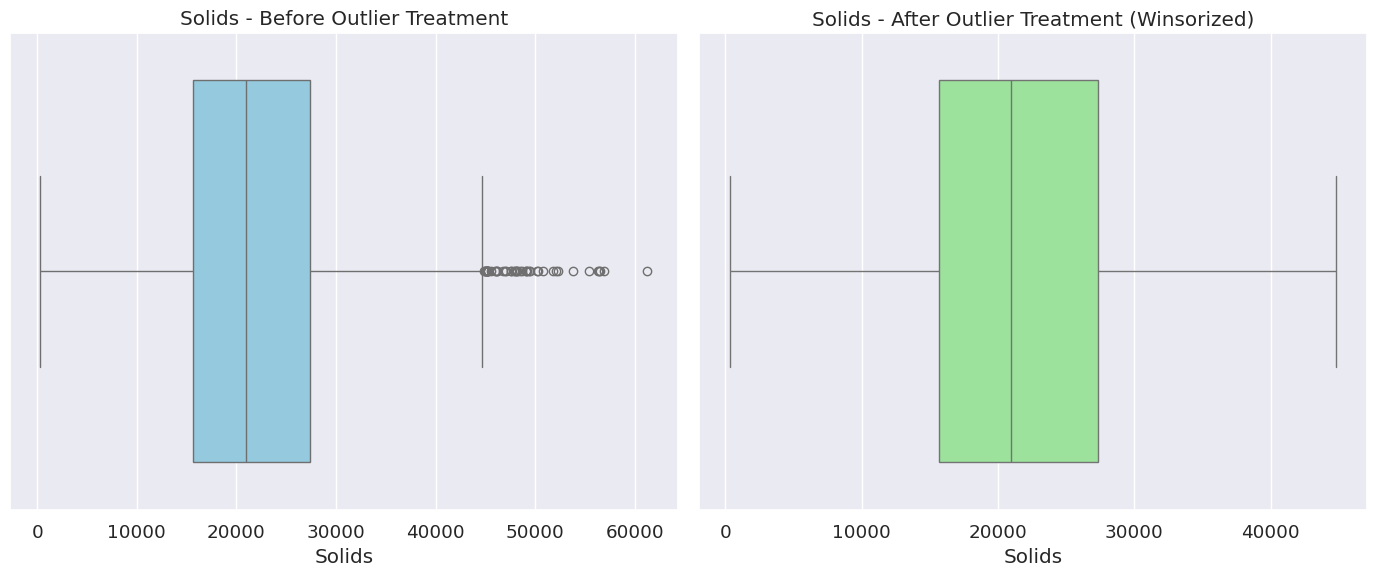

Column Chloramines: 61 outliers detected (1.86%)
  - Lower bound: 3.1462, Upper bound: 11.0961


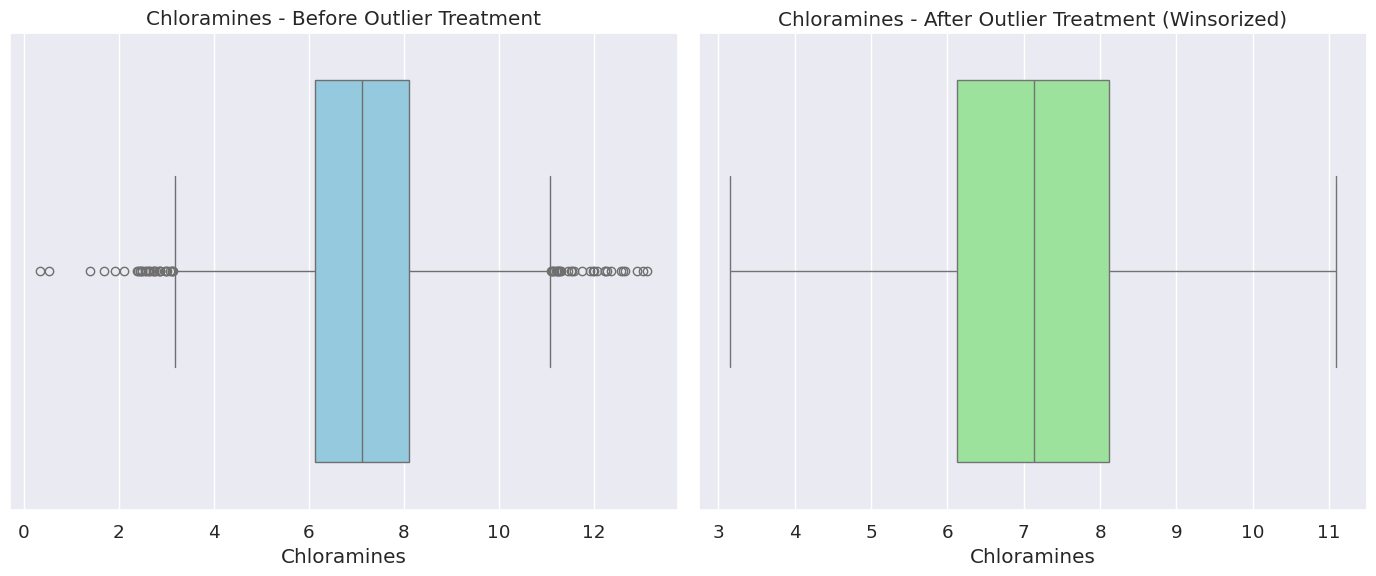

Column Sulfate: 264 outliers detected (8.06%)
  - Lower bound: 267.1580, Upper bound: 400.3224


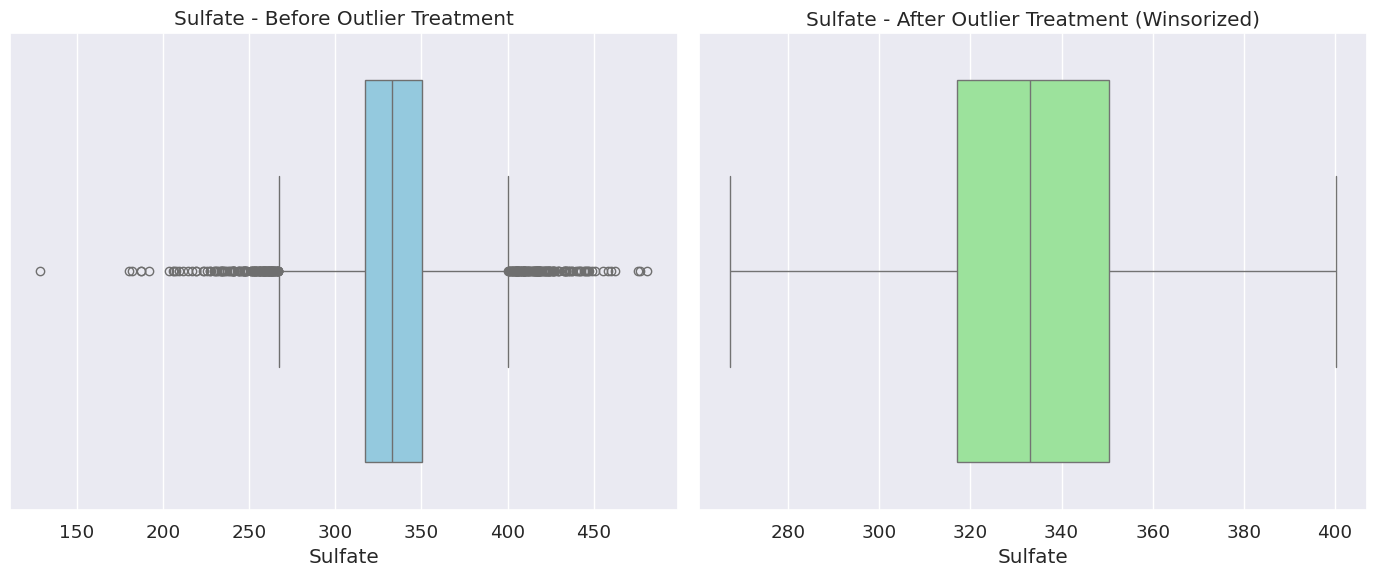

Column Conductivity: 11 outliers detected (0.34%)
  - Lower bound: 191.6476, Upper bound: 655.8791


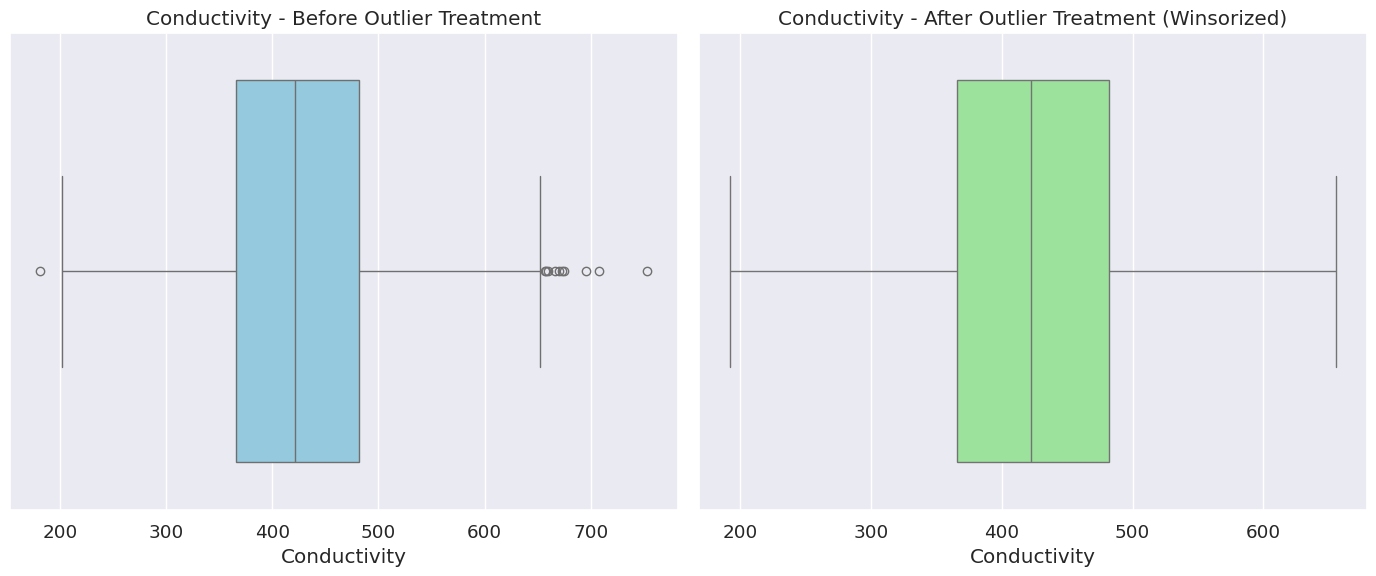

Column Organic_carbon: 25 outliers detected (0.76%)
  - Lower bound: 5.3280, Upper bound: 23.2954


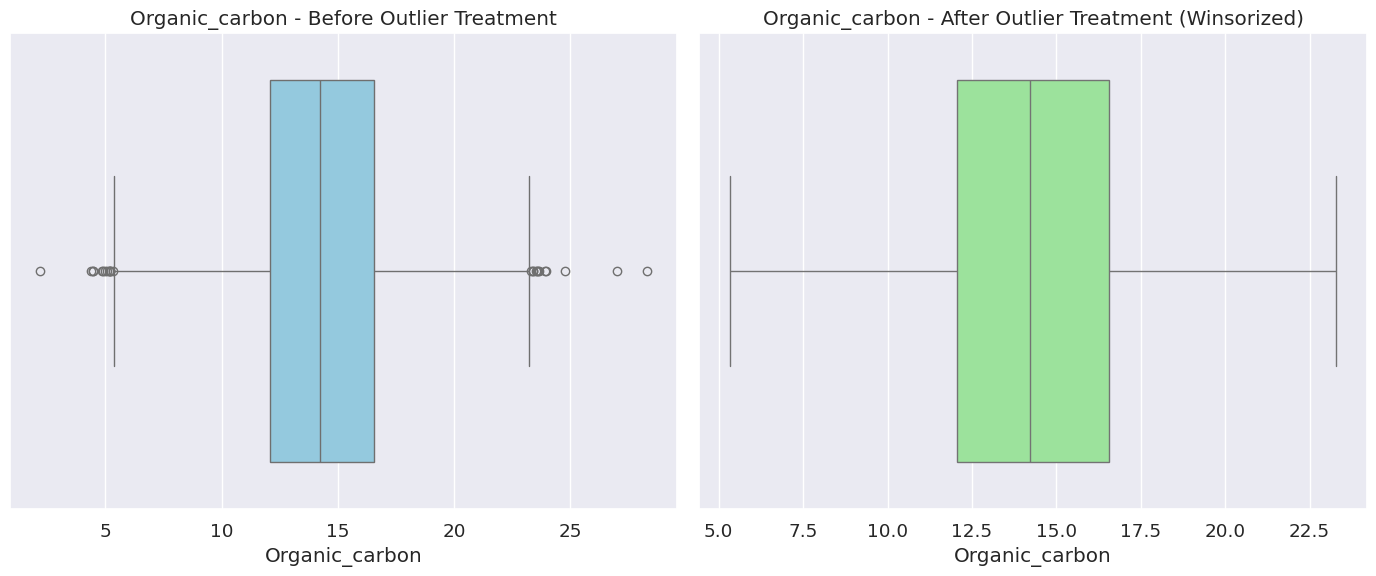

Column Trihalomethanes: 54 outliers detected (1.65%)
  - Lower bound: 26.6192, Upper bound: 106.6950


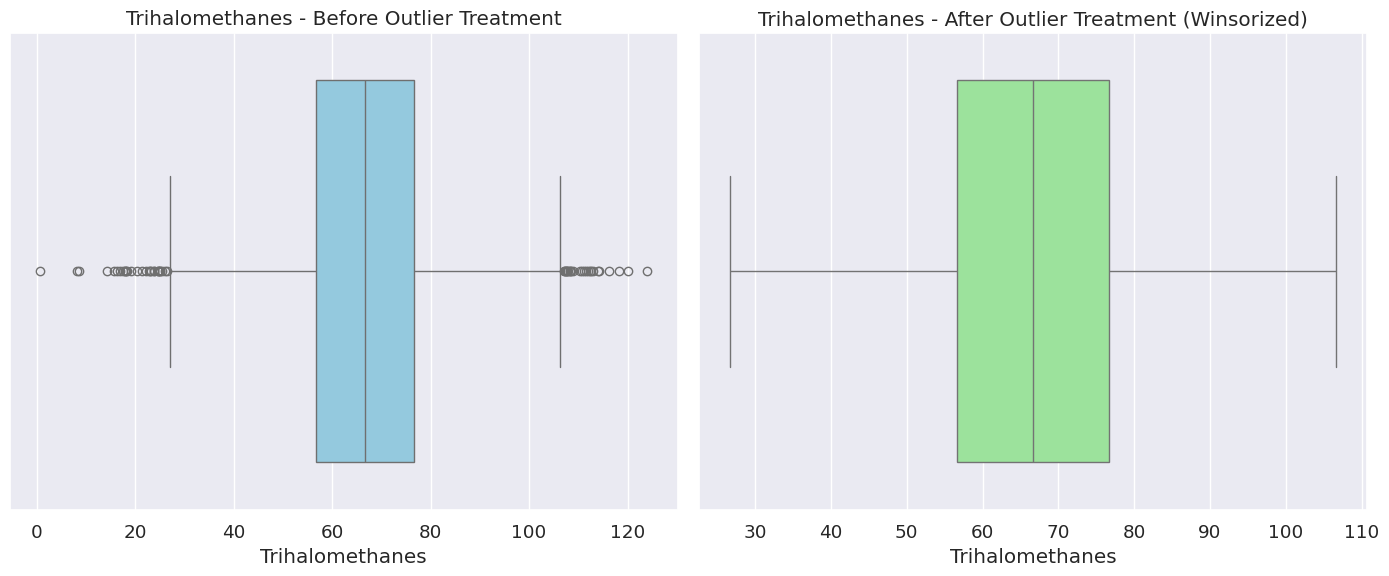

Column Turbidity: 19 outliers detected (0.58%)
  - Lower bound: 1.8488, Upper bound: 6.0912


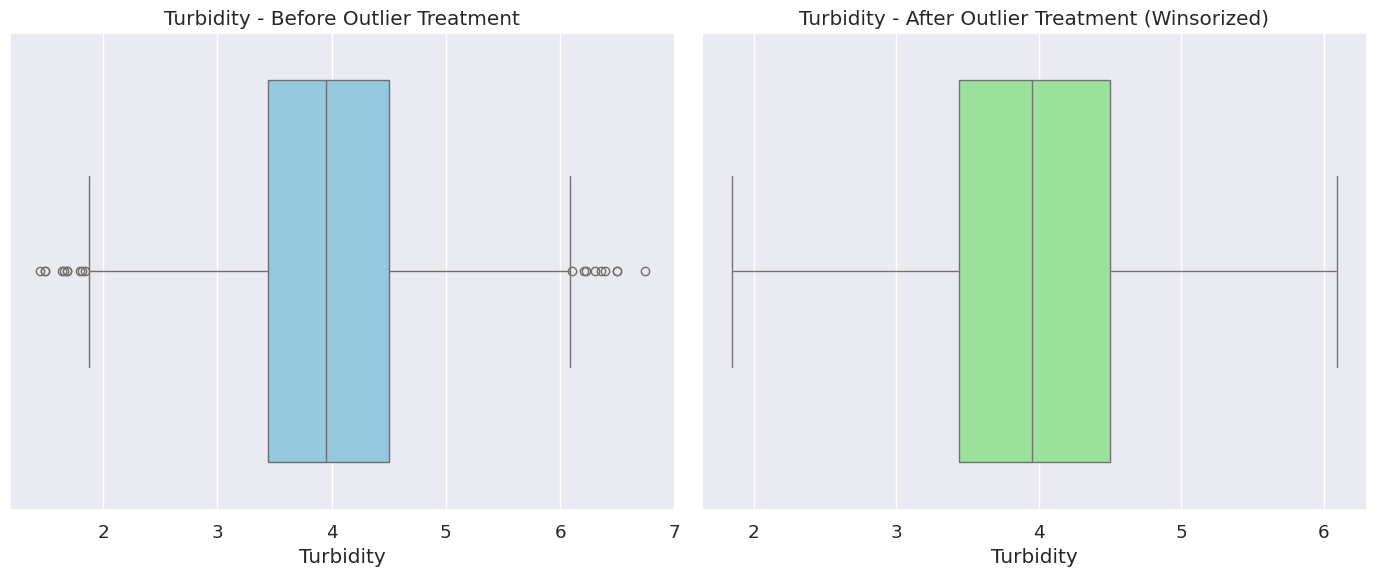

In [38]:
# Detect and handle outliers using IQR method
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

# Function to winsorize outliers
def winsorize_outliers(df, column, lower_bound, upper_bound):
    df_copy = df.copy()
    df_copy.loc[df_copy[column] < lower_bound, column] = lower_bound
    df_copy.loc[df_copy[column] > upper_bound, column] = upper_bound
    return df_copy

# Check for outliers in numeric columns (excluding WQI column)
numeric_columns_excl_wqi = [col for col in numeric_columns if col != wqi_column]

# Store original data for comparison
df_before_outlier_treatment = df.copy()

# Detect and handle outliers
for col in numeric_columns_excl_wqi:
    outliers, lower_bound, upper_bound = detect_outliers_iqr(df, col)
    outlier_percentage = (len(outliers) / len(df)) * 100

    print(f"Column {col}: {len(outliers)} outliers detected ({outlier_percentage:.2f}%)")
    print(f"  - Lower bound: {lower_bound:.4f}, Upper bound: {upper_bound:.4f}")

    # Winsorize outliers
    df = winsorize_outliers(df, col, lower_bound, upper_bound)

    # Plot before and after outlier treatment
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    sns.boxplot(x=df_before_outlier_treatment[col], color='skyblue')
    plt.title(f'{col} - Before Outlier Treatment')

    plt.subplot(1, 2, 2)
    sns.boxplot(x=df[col], color='lightgreen')
    plt.title(f'{col} - After Outlier Treatment (Winsorized)')

    plt.tight_layout()
    plt.show()

WQI Label Counts:
WQI_Label
Moderate      479
Poor         2509
Very Poor     288
Name: count, dtype: int64


/tmp/ipython-input-2263071183.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='WQI_Label', data=df, palette='viridis', order=['Very Poor', 'Poor', 'Moderate'])


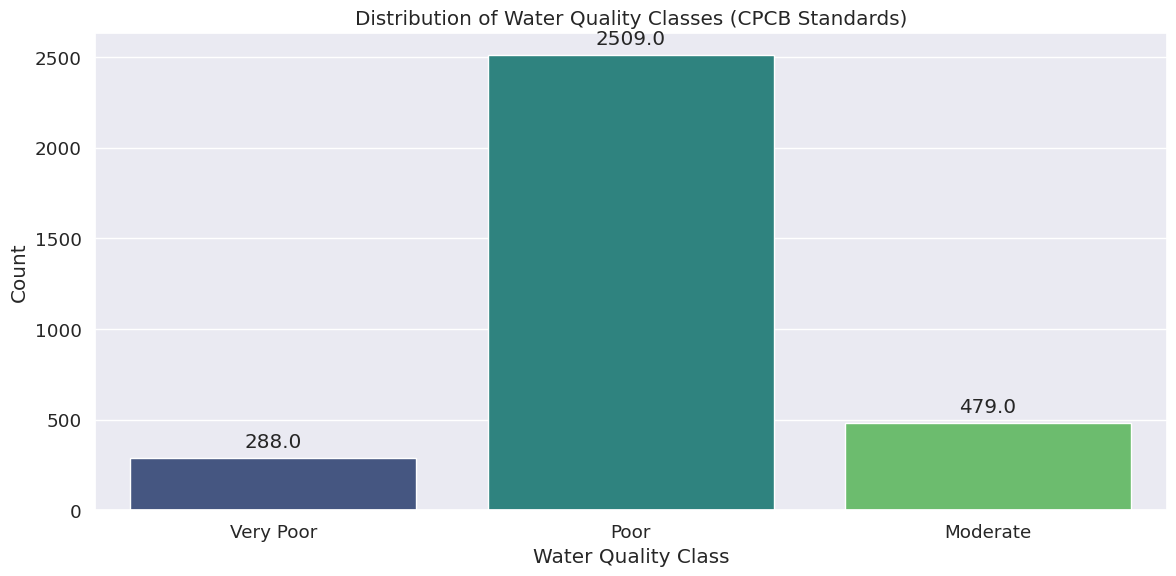

In [39]:
# Create WQI_Label based on CPCB standards
def assign_wqi_label(wqi):
    if wqi <= 25:
        return 'Very Poor'
    elif wqi <= 50:
        return 'Poor'
    elif wqi <= 70:
        return 'Moderate'
    elif wqi <= 90:
        return 'Good'
    else:
        return 'Excellent'

# Create WQI_Label column
df['WQI_Label'] = df[wqi_column].apply(assign_wqi_label)

# Create a numeric version of WQI_Label for modeling
label_mapping = {
    'Very Poor': 0,
    'Poor': 1,
    'Moderate': 2,
    'Good': 3,
    'Excellent': 4
}

df['WQI_Label_Numeric'] = df['WQI_Label'].map(label_mapping)

# Show the counts of each class
wqi_label_counts = df['WQI_Label'].value_counts().sort_index()
print("WQI Label Counts:")
print(wqi_label_counts)

# Plot the distribution of WQI labels
plt.figure(figsize=(12, 6))
ax = sns.countplot(x='WQI_Label', data=df, palette='viridis', order=['Very Poor', 'Poor', 'Moderate'])
plt.title('Distribution of Water Quality Classes (CPCB Standards)')
plt.xlabel('Water Quality Class')
plt.ylabel('Count')

# Add count labels on top of bars
for p in ax.patches:
    ax.annotate(f'{p.get_height()}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'bottom',
                xytext = (0, 5), textcoords = 'offset points')

plt.tight_layout()
plt.show()

## 4. Exploratory Data Analysis (EDA)

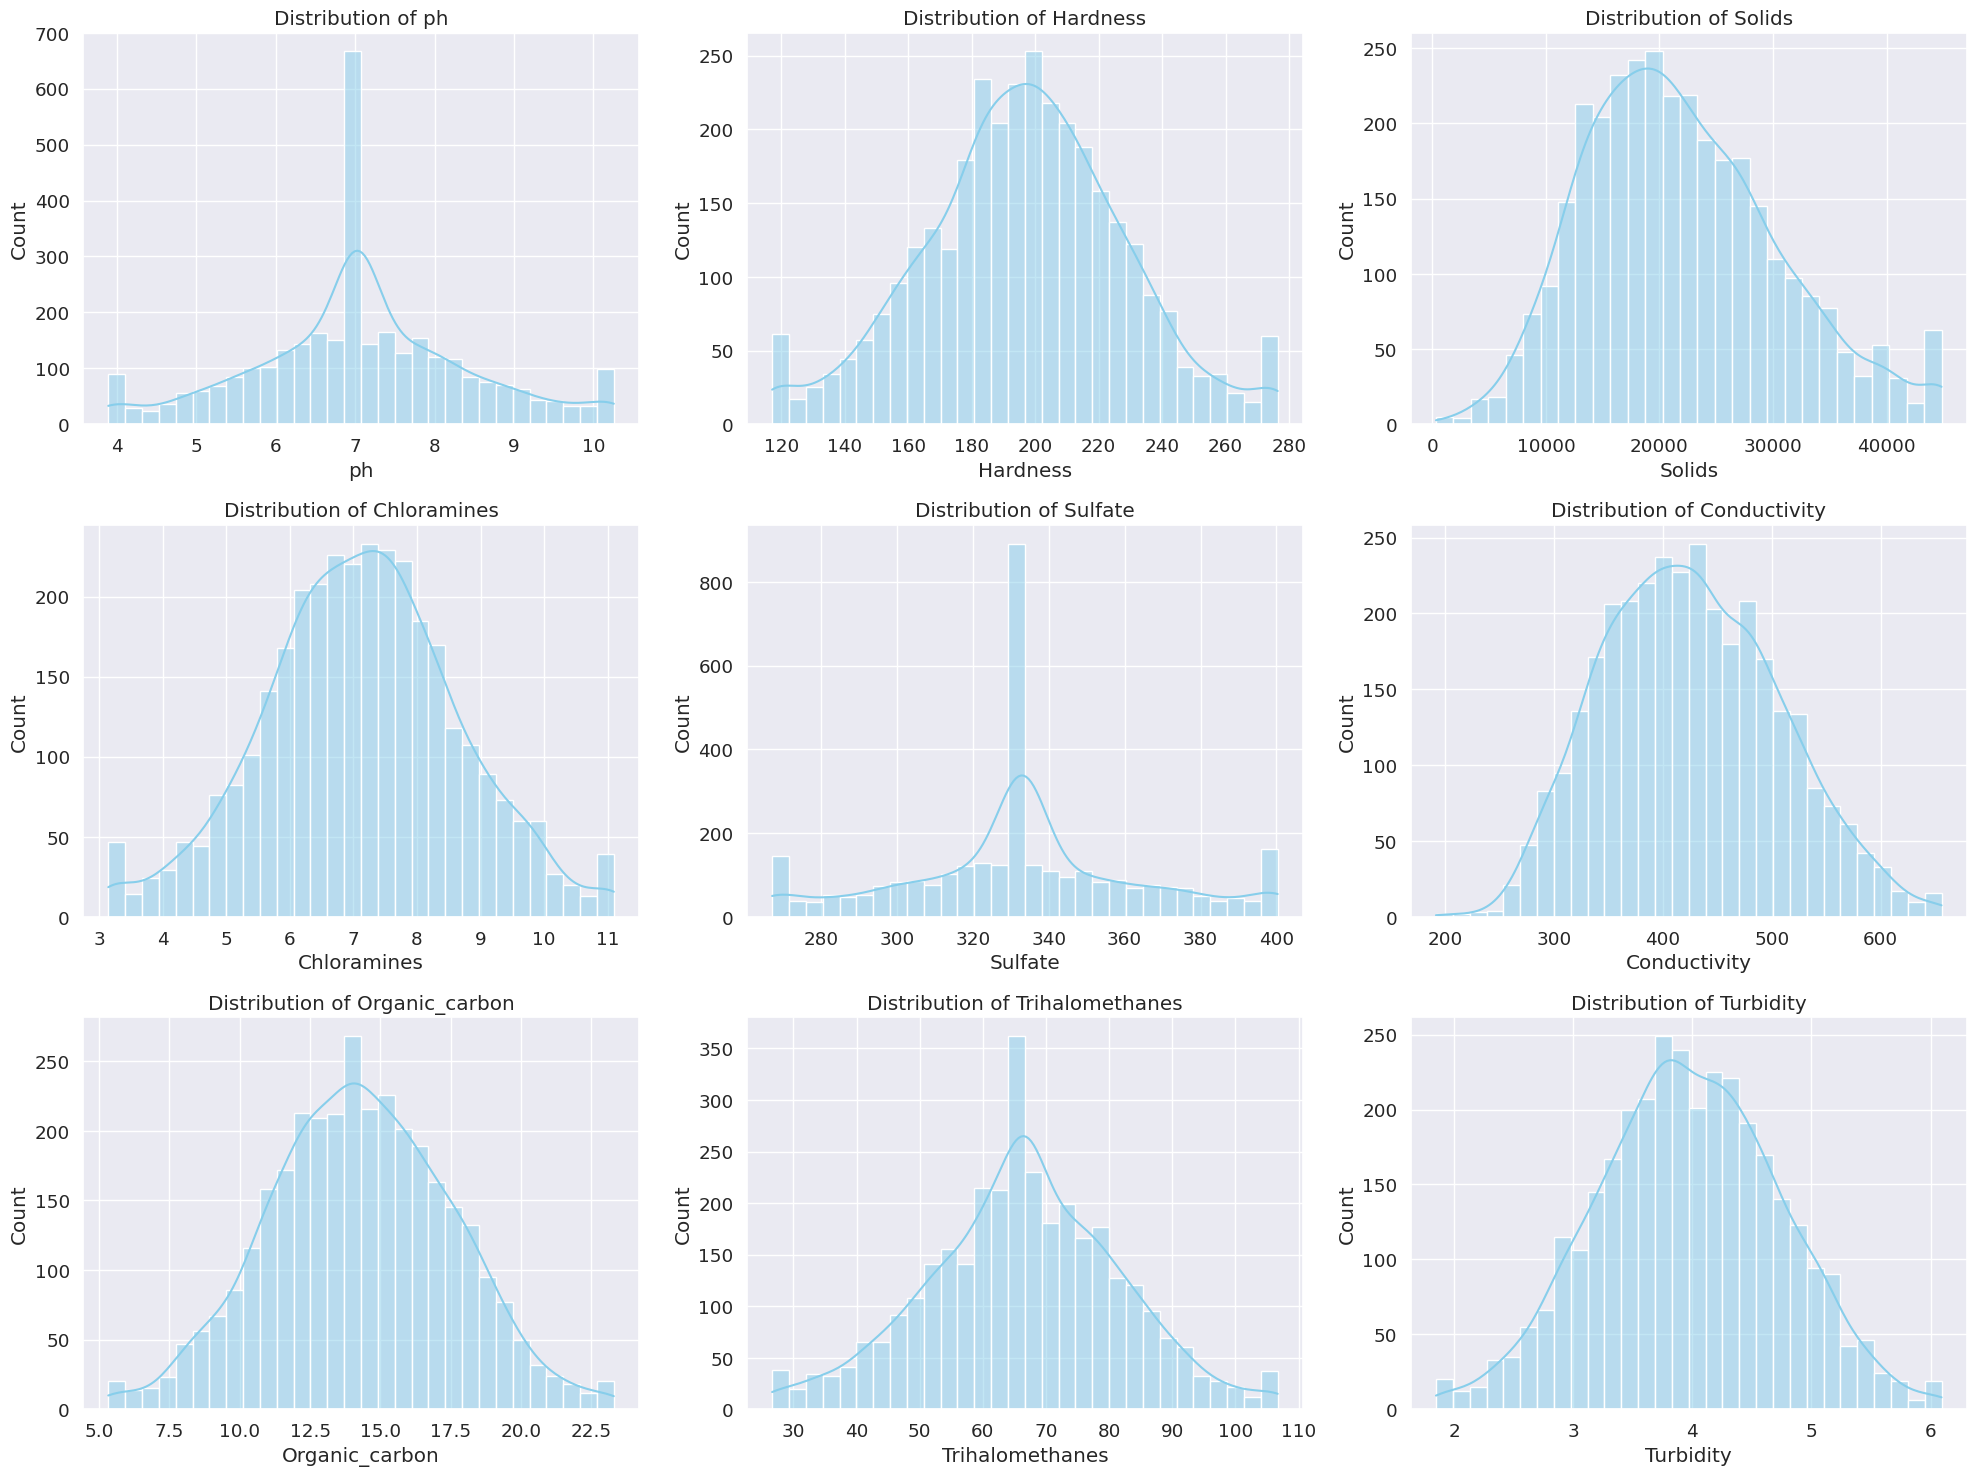

In [40]:
# Univariate analysis - histograms for numeric features
plt.figure(figsize=(20, 15))
for i, col in enumerate(numeric_columns_excl_wqi, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df[col], kde=True, color='skyblue')
    plt.title(f'Distribution of {col}')
    plt.tight_layout()
plt.show()

/tmp/ipython-input-3131260127.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='WQI_Label', y=col, data=df, palette='viridis',


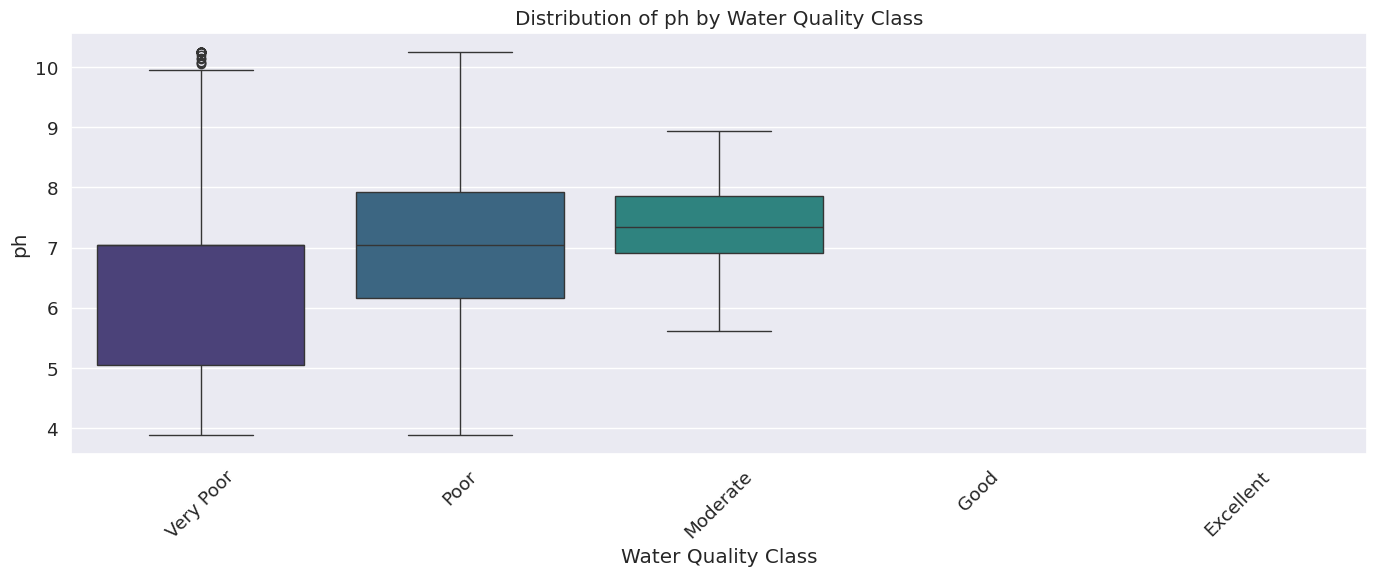

/tmp/ipython-input-3131260127.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='WQI_Label', y=col, data=df, palette='viridis',


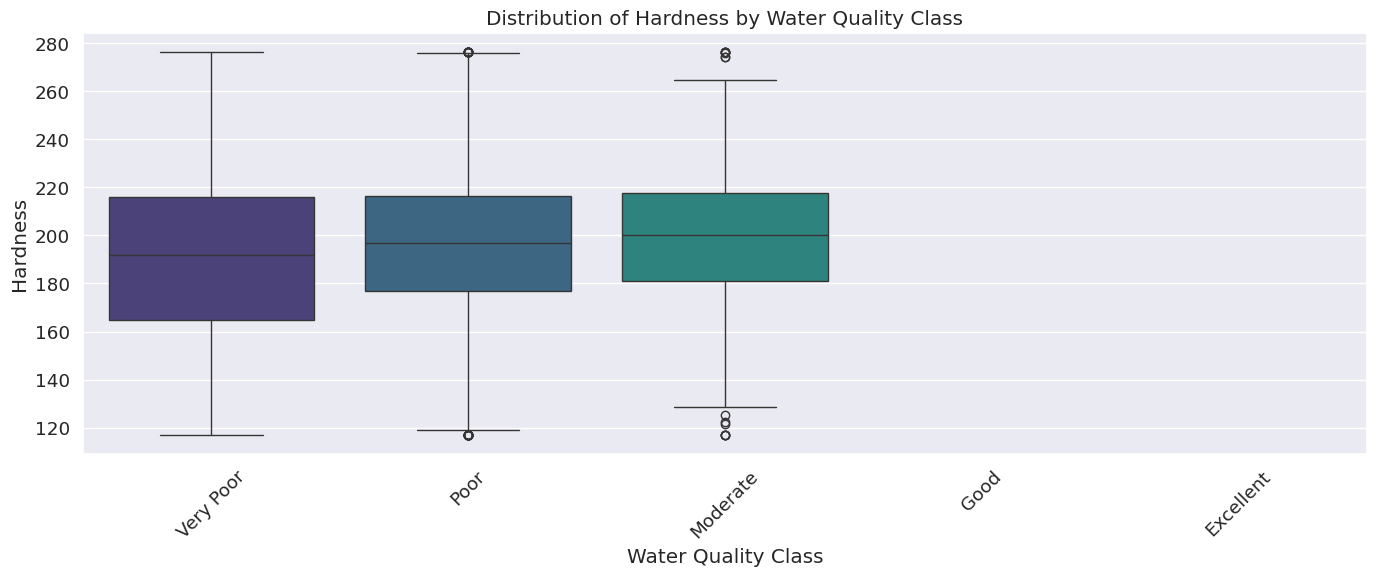

/tmp/ipython-input-3131260127.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='WQI_Label', y=col, data=df, palette='viridis',


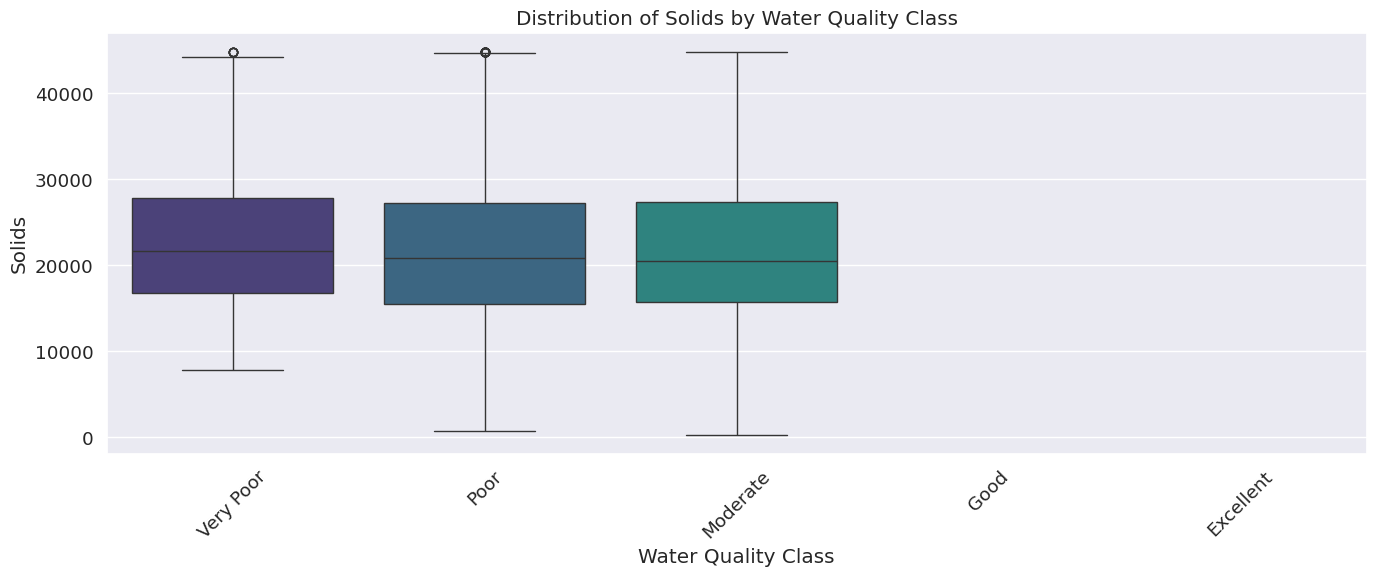

/tmp/ipython-input-3131260127.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='WQI_Label', y=col, data=df, palette='viridis',


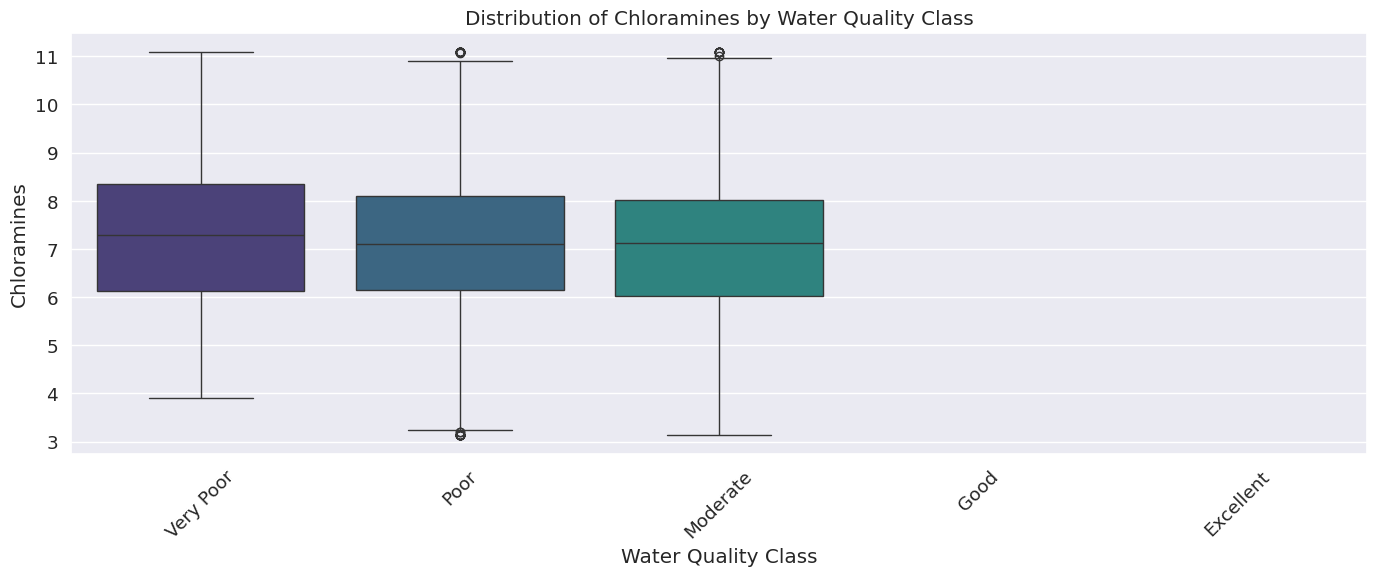

/tmp/ipython-input-3131260127.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='WQI_Label', y=col, data=df, palette='viridis',


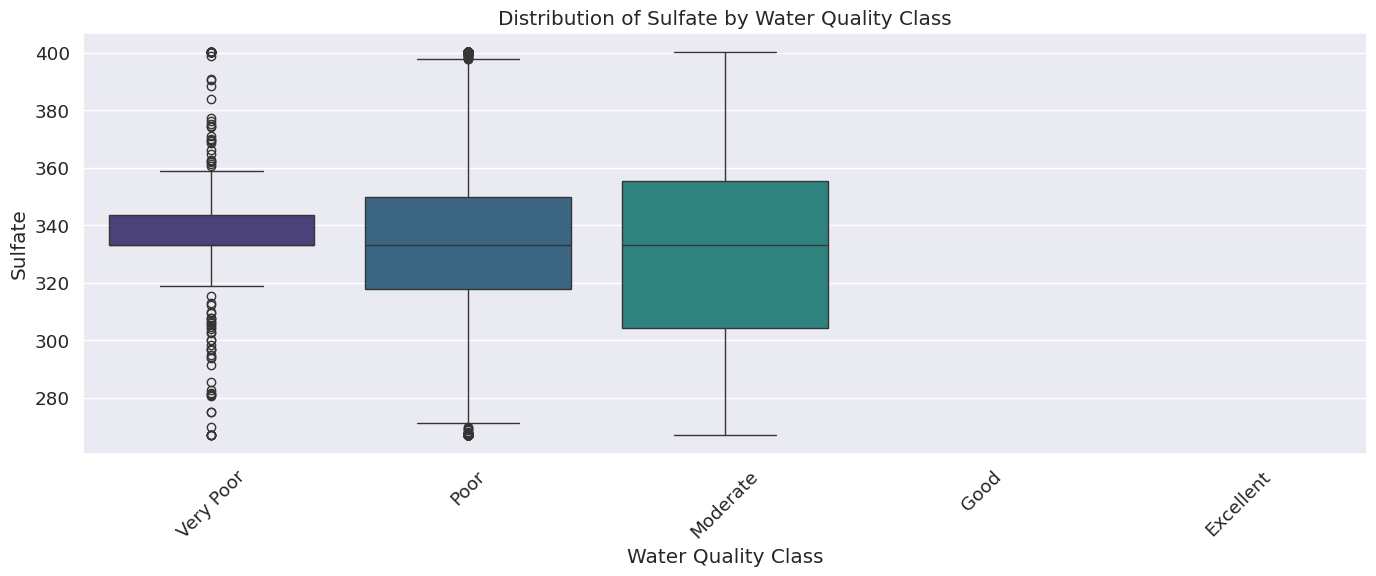

/tmp/ipython-input-3131260127.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='WQI_Label', y=col, data=df, palette='viridis',


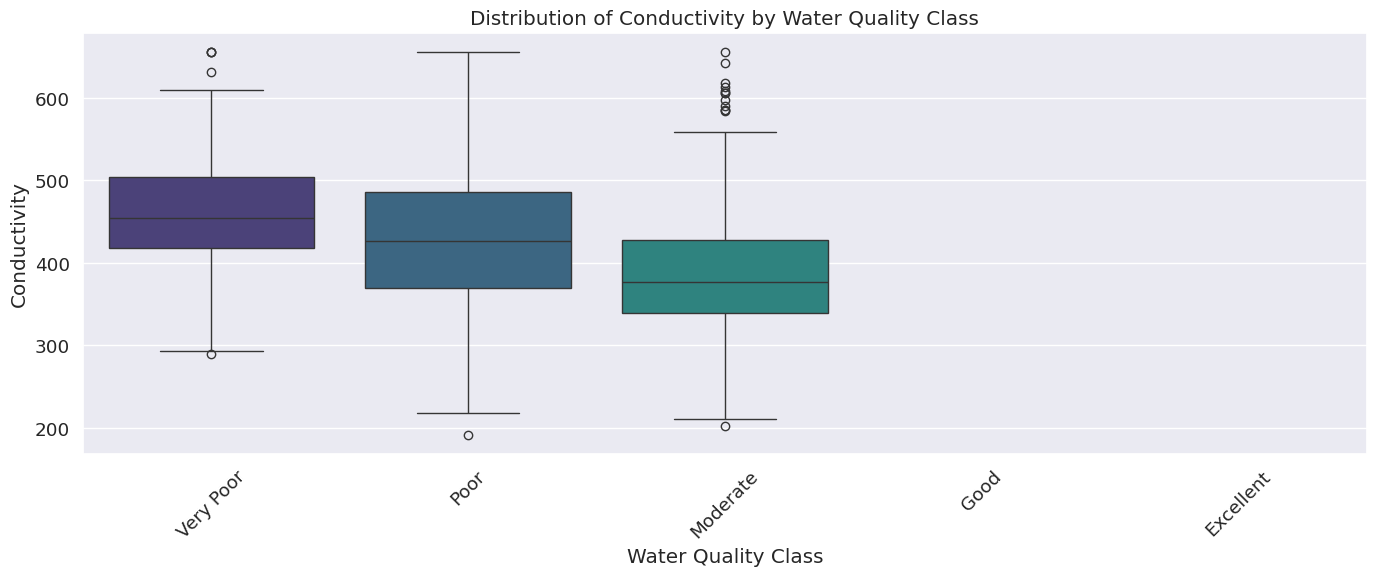

/tmp/ipython-input-3131260127.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='WQI_Label', y=col, data=df, palette='viridis',


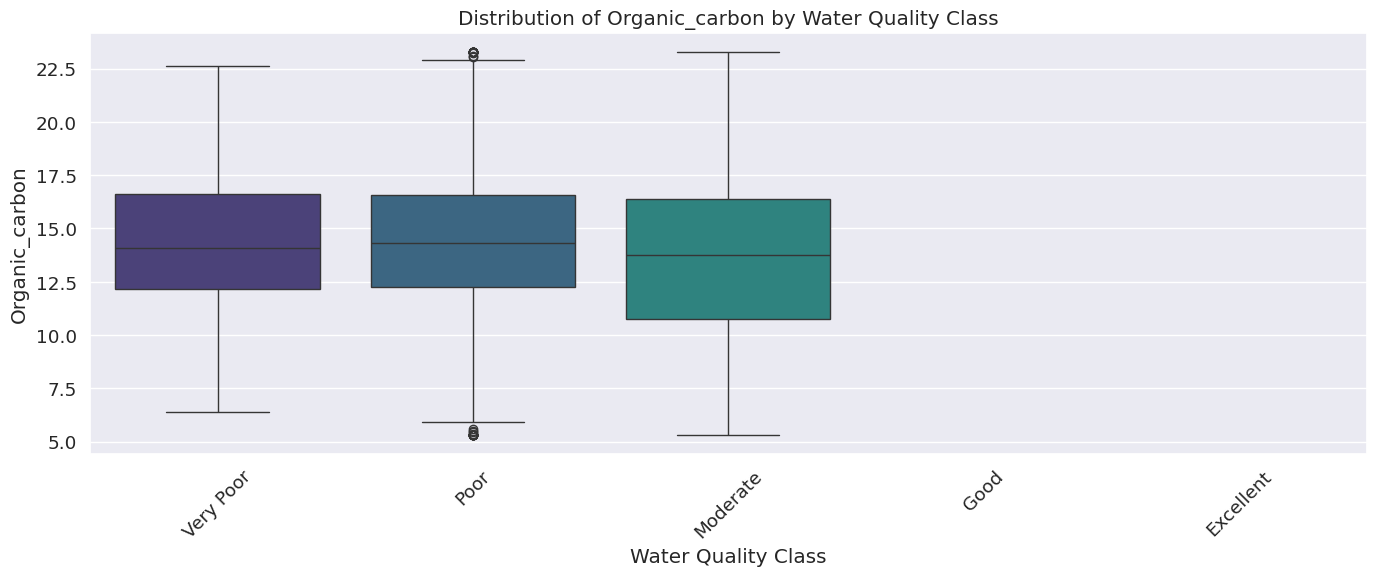

/tmp/ipython-input-3131260127.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='WQI_Label', y=col, data=df, palette='viridis',


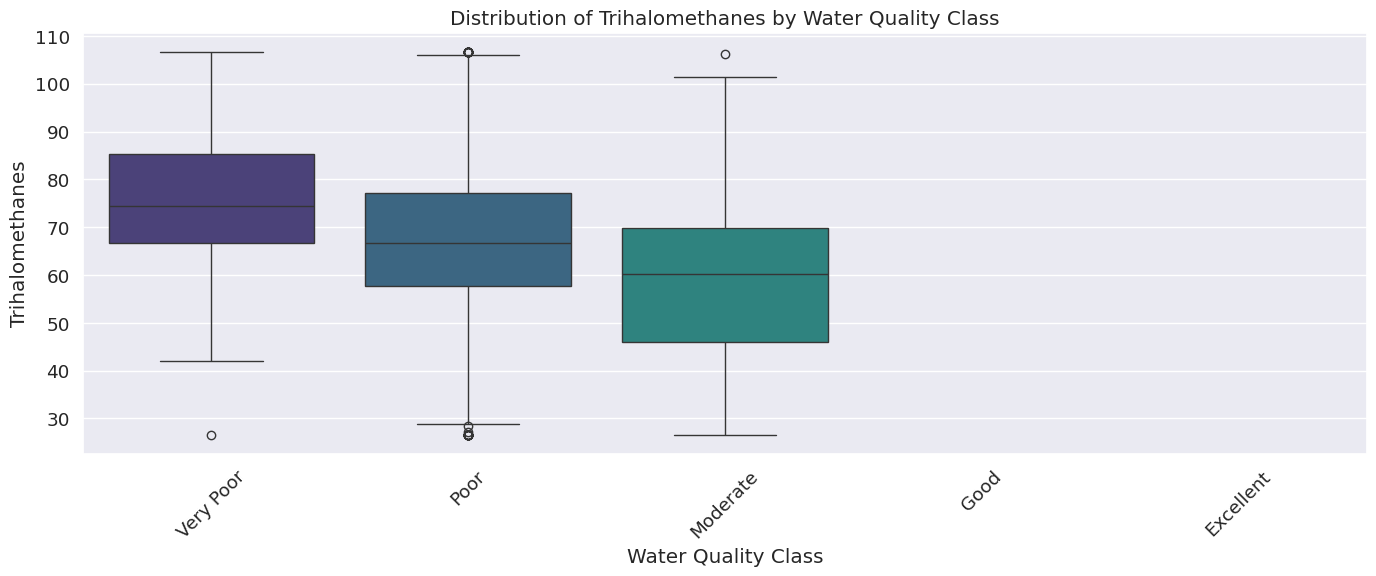

/tmp/ipython-input-3131260127.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='WQI_Label', y=col, data=df, palette='viridis',


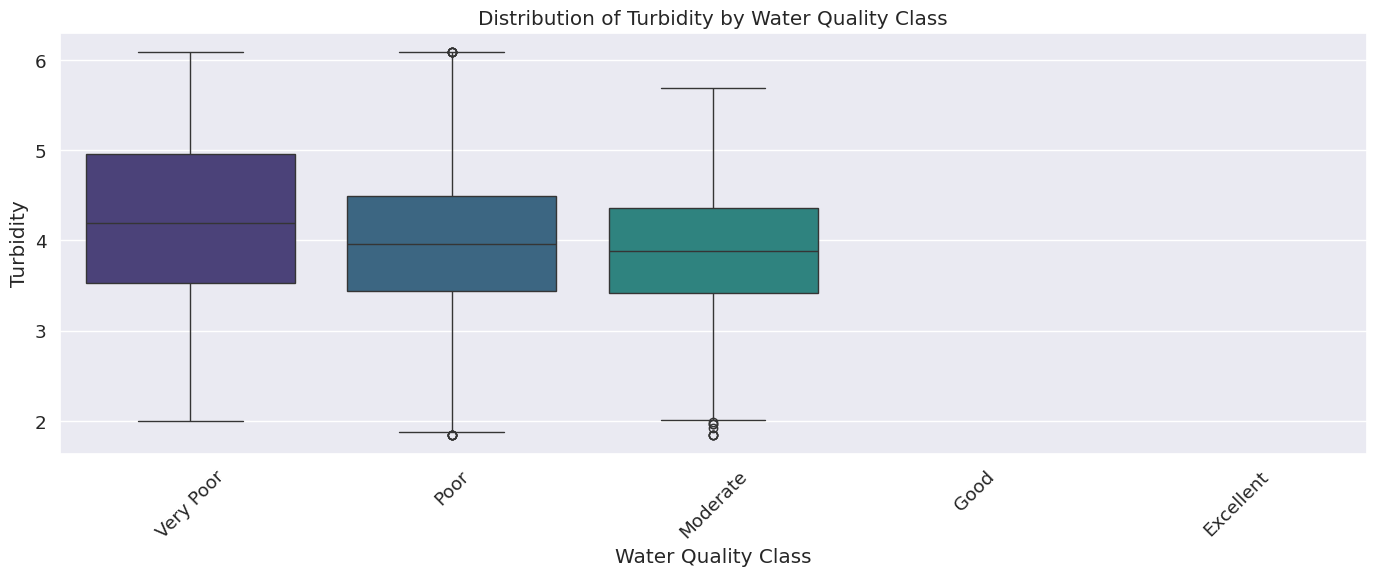

In [41]:
# Boxplots for numeric features by WQI_Label
for col in numeric_columns_excl_wqi:
    plt.figure(figsize=(14, 6))
    sns.boxplot(x='WQI_Label', y=col, data=df, palette='viridis',
                order=['Very Poor', 'Poor', 'Moderate', 'Good', 'Excellent'])
    plt.title(f'Distribution of {col} by Water Quality Class')
    plt.xlabel('Water Quality Class')
    plt.ylabel(col)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

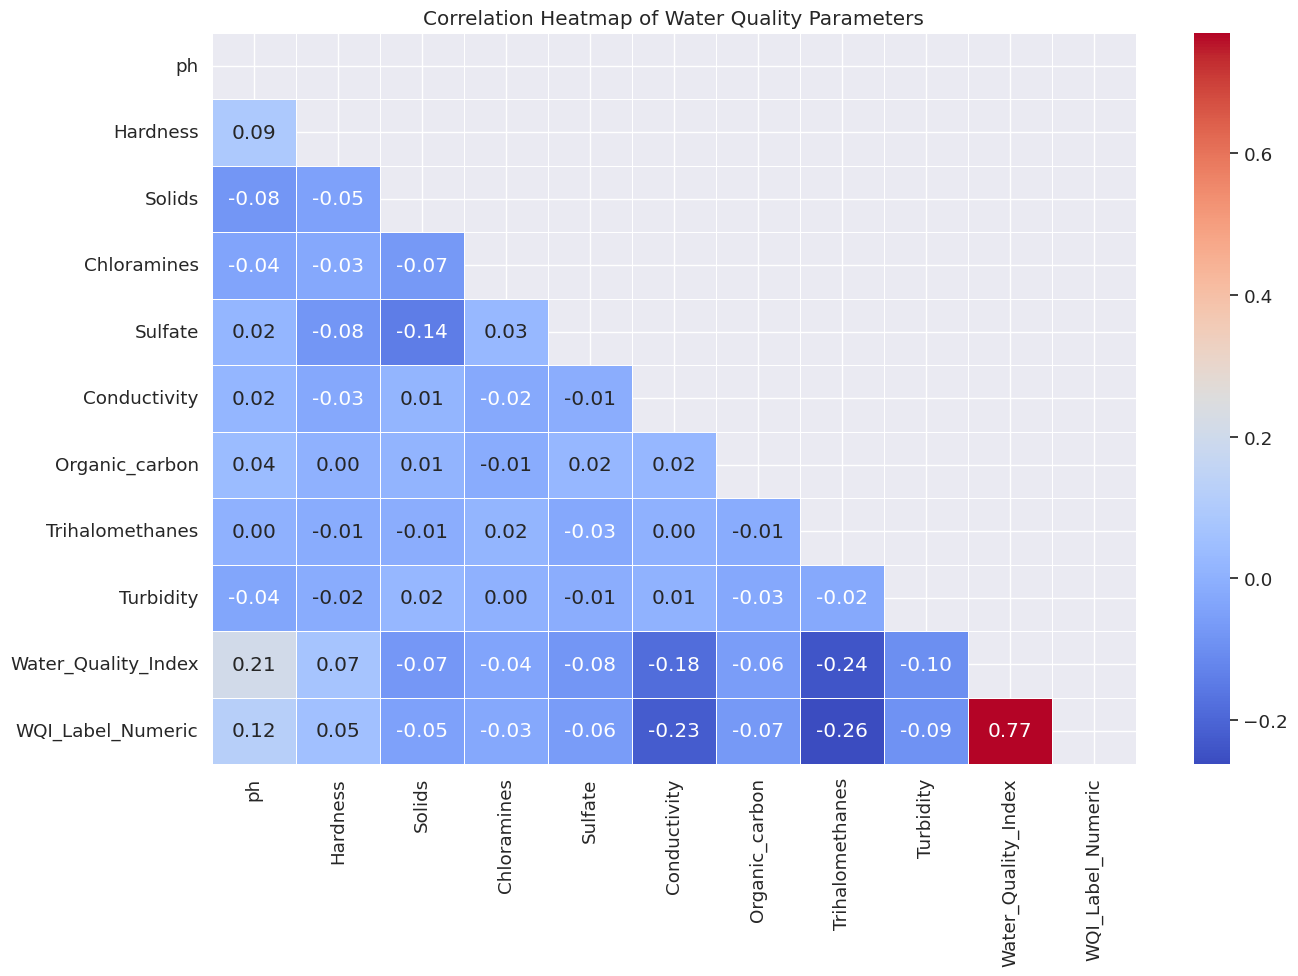

In [42]:
# Correlation heatmap
plt.figure(figsize=(14, 10))
correlation_matrix = df.drop('WQI_Label', axis=1).corr()
mask = np.triu(correlation_matrix)
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', mask=mask, linewidths=0.5)
plt.title('Correlation Heatmap of Water Quality Parameters')
plt.tight_layout()
plt.show()

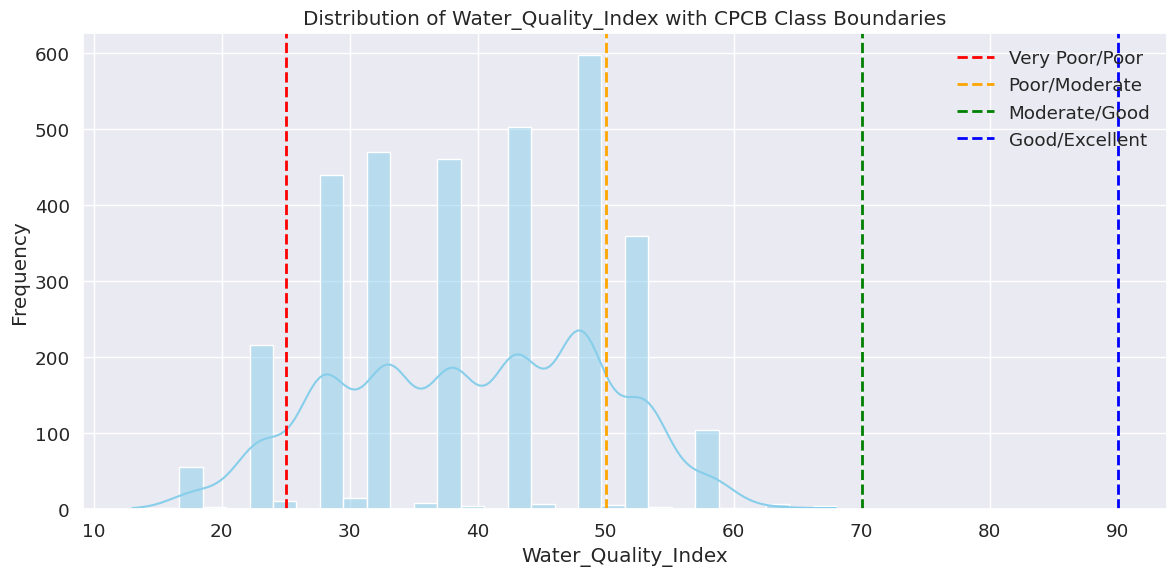

In [43]:
# Plot WQI distribution with vertical lines at class boundaries
plt.figure(figsize=(12, 6))
sns.histplot(df[wqi_column], bins=30, kde=True, color='skyblue')

# Add vertical lines at class boundaries
boundaries = [25, 50, 70, 90]
labels = ['Very Poor/Poor', 'Poor/Moderate', 'Moderate/Good', 'Good/Excellent']
colors = ['red', 'orange', 'green', 'blue']

for boundary, label, color in zip(boundaries, labels, colors):
    plt.axvline(x=boundary, color=color, linestyle='--', linewidth=2, label=label)

plt.title(f'Distribution of {wqi_column} with CPCB Class Boundaries')
plt.xlabel(wqi_column)
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()

## 5. Feature Selection and Data Splitting

In [44]:
# Prepare features and target
X = df.drop([wqi_column, 'WQI_Label', 'WQI_Label_Numeric'], axis=1)
y = df['WQI_Label_Numeric']  # Using numeric labels for modeling

# Display feature set
print("Features used for modeling:")
print(X.columns.tolist())
print(f"\nShape of feature set: {X.shape}")

# Split the data into training and testing sets (80/20 split with stratification)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print(f"\nTraining set shape: {X_train.shape}, {y_train.shape}")
print(f"Testing set shape: {X_test.shape}, {y_test.shape}")

Features used for modeling:
['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity', 'Organic_carbon', 'Trihalomethanes', 'Turbidity']

Shape of feature set: (3276, 9)

Training set shape: (2620, 9), (2620,)
Testing set shape: (656, 9), (656,)


In [45]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert to DataFrame for better readability
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X.columns)

print("Standardized features (first 5 rows):")
X_train_scaled_df.head()

Standardized features (first 5 rows):


,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity
0,-2.016211,-0.917213,0.294243,0.173152,-1.142024,-0.952532,-0.247007,-0.770628,-0.266921
1,1.255307,-0.000438,-0.492780,1.186986,1.453979,0.758950,0.994255,-0.336634,-0.229249
2,1.033088,-2.106910,1.187764,-0.699231,2.094544,1.597289,0.520621,1.364208,0.223986
3,-1.378989,-0.224567,1.547859,-0.255844,0.228524,-1.175989,-0.421798,-0.326164,0.862733
4,0.499619,-0.107943,-0.726942,0.493683,-0.290491,-1.547748,-0.277852,1.466439,-0.848990


## 6. Handle Class Imbalance with SMOTE

Class distribution in training set before SMOTE:
WQI_Label_Numeric
0     230
1    2007
2     383
Name: count, dtype: int64

Class imbalance ratio: 8.73

Applying SMOTE to balance the training data...

Class distribution in training set after SMOTE:
WQI_Label_Numeric
0    2007
1    2007
2    2007
Name: count, dtype: int64


/tmp/ipython-input-788071673.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_train, palette='viridis')
/tmp/ipython-input-788071673.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_train_resampled, palette='viridis')


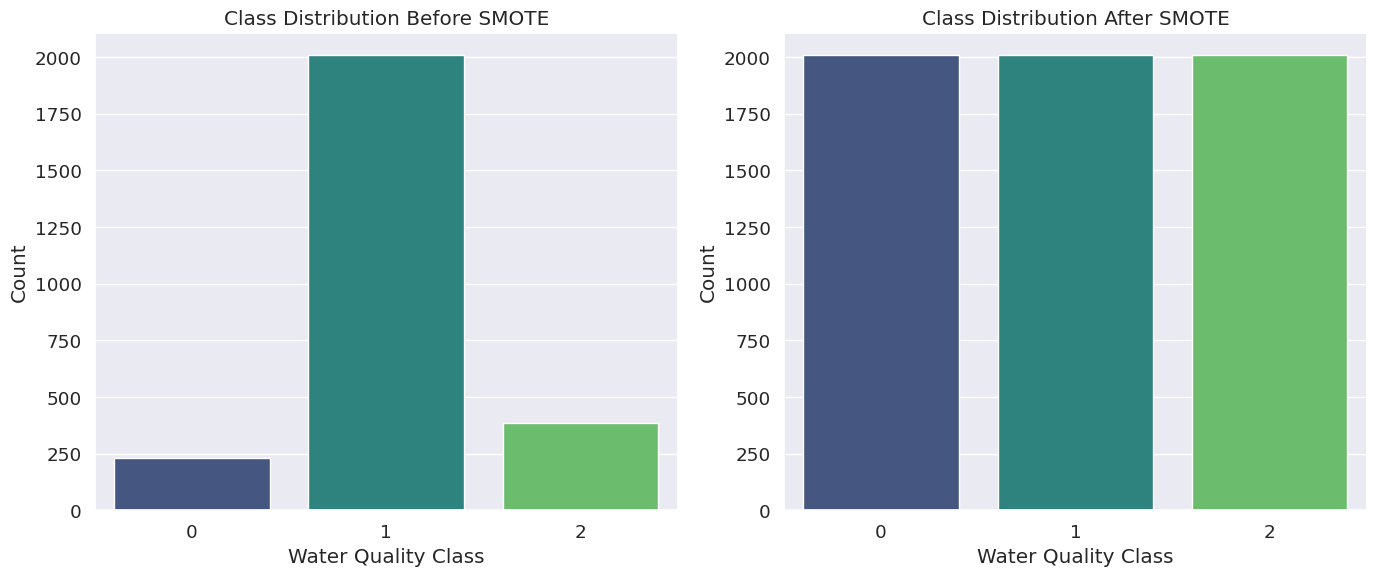

In [46]:
# Check class distribution in training set
train_class_counts = pd.Series(y_train).value_counts().sort_index()
print("Class distribution in training set before SMOTE:")
print(train_class_counts)

# Calculate class imbalance ratio (max count / min count)
imbalance_ratio = train_class_counts.max() / train_class_counts.min()
print(f"\nClass imbalance ratio: {imbalance_ratio:.2f}")

# Apply SMOTE if there's significant class imbalance (ratio > 1.5)
if imbalance_ratio > 1.5:
    print("\nApplying SMOTE to balance the training data...")
    smote = SMOTE(random_state=RANDOM_STATE)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

    # Check class distribution after SMOTE
    resampled_class_counts = pd.Series(y_train_resampled).value_counts().sort_index()
    print("\nClass distribution in training set after SMOTE:")
    print(resampled_class_counts)

    # Plot before and after SMOTE
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    sns.countplot(x=y_train, palette='viridis')
    plt.title('Class Distribution Before SMOTE')
    plt.xlabel('Water Quality Class')
    plt.ylabel('Count')

    plt.subplot(1, 2, 2)
    sns.countplot(x=y_train_resampled, palette='viridis')
    plt.title('Class Distribution After SMOTE')
    plt.xlabel('Water Quality Class')
    plt.ylabel('Count')

    plt.tight_layout()
    plt.show()

    # Use the resampled data for training
    X_train_scaled = X_train_resampled
    y_train = y_train_resampled
else:
    print("\nClass imbalance is not significant. Skipping SMOTE.")

## 7. Model Training and Evaluation


--------------------------------------------------
Model: Logistic Regression
--------------------------------------------------
Accuracy: 0.4131
Precision (macro): 0.4162
Recall (macro): 0.5511
F1 Score (macro): 0.3821
Cross-validation F1 (5-fold): 0.5895 ± 0.0104

Confusion Matrix:
[[ 36  21   1]
 [171 168 163]
 [  5  24  67]]

Classification Report:
              precision    recall  f1-score   support

   Very Poor       0.17      0.62      0.27        58
        Poor       0.79      0.33      0.47       502
    Moderate       0.29      0.70      0.41        96

    accuracy                           0.41       656
   macro avg       0.42      0.55      0.38       656
weighted avg       0.66      0.41      0.44       656



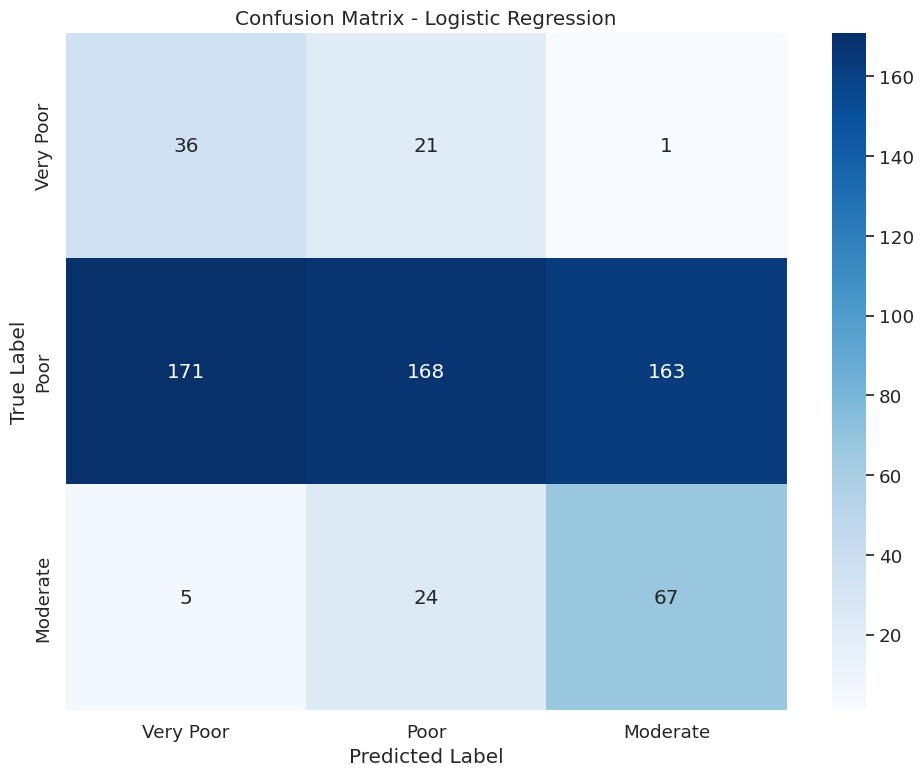


--------------------------------------------------
Model: Decision Tree
--------------------------------------------------
Accuracy: 0.8171
Precision (macro): 0.6923
Recall (macro): 0.7862
F1 Score (macro): 0.7249
Cross-validation F1 (5-fold): 0.8752 ± 0.0108

Confusion Matrix:
[[ 41  17   0]
 [ 58 416  28]
 [  0  17  79]]

Classification Report:
              precision    recall  f1-score   support

   Very Poor       0.41      0.71      0.52        58
        Poor       0.92      0.83      0.87       502
    Moderate       0.74      0.82      0.78        96

    accuracy                           0.82       656
   macro avg       0.69      0.79      0.72       656
weighted avg       0.85      0.82      0.83       656



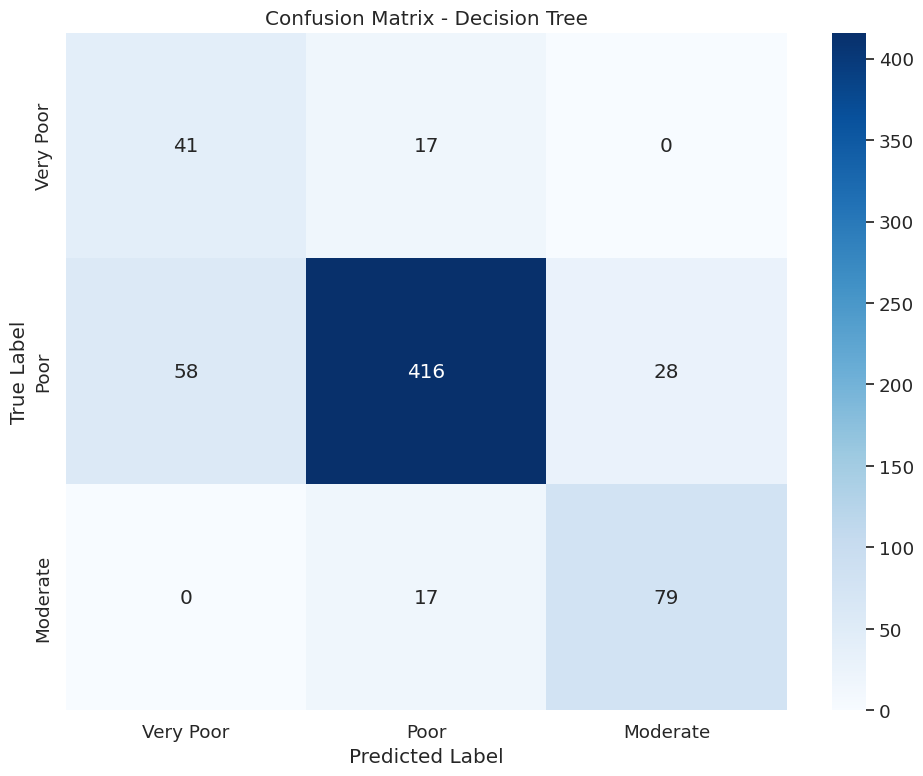

In [ ]:
# Define models to train
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=RANDOM_STATE),
    'Decision Tree': DecisionTreeClassifier(random_state=RANDOM_STATE),
    'Random Forest': RandomForestClassifier(random_state=RANDOM_STATE),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'SVC': SVC(probability=True, random_state=RANDOM_STATE),
    'Gradient Boosting': GradientBoostingClassifier(random_state=RANDOM_STATE)
}

# Add XGBoost if available
if xgboost_available:
    models['XGBoost'] = XGBClassifier(random_state=RANDOM_STATE)

# Function to evaluate a model
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')

    # Cross-validation score
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1_macro')
    cv_mean = cv_scores.mean()
    cv_std = cv_scores.std()

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Classification report
    report = classification_report(y_test, y_pred, target_names=['Very Poor', 'Poor', 'Moderate'])

    # Print results
    print(f"\n{'-'*50}")
    print(f"Model: {model_name}")
    print(f"{'-'*50}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision (macro): {precision:.4f}")
    print(f"Recall (macro): {recall:.4f}")
    print(f"F1 Score (macro): {f1:.4f}")
    print(f"Cross-validation F1 (5-fold): {cv_mean:.4f} ± {cv_std:.4f}")

    print("\nConfusion Matrix:")
    print(cm)

    print("\nClassification Report:")
    print(report)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Very Poor', 'Poor', 'Moderate'],
                yticklabels=['Very Poor', 'Poor', 'Moderate'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()

    return {
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'CV F1 (mean)': cv_mean,
        'CV F1 (std)': cv_std,
        'Model Object': model
    }

# Train and evaluate all models
results = []

for name, model in models.items():
    result = evaluate_model(model, X_train_scaled, y_train, X_test_scaled, y_test, name)
    results.append(result)

# Create a DataFrame with results
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('F1 Score', ascending=False).reset_index(drop=True)

# Display sorted results
print("\nModel Performance Summary (sorted by F1 Score):")
display_cols = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'CV F1 (mean)', 'CV F1 (std)']
results_df[display_cols]

## 8. Hyperparameter Tuning for Top Models

In [ ]:
# Get the top 2 models for hyperparameter tuning
top_models = results_df.iloc[:2]
print(f"Top 2 models for hyperparameter tuning:\n{top_models[['Model', 'F1 Score']]}")

# Define hyperparameter grids for different models
param_grids = {
    'Logistic Regression': {
        'C': [0.01, 0.1, 1, 10, 100],
        'solver': ['liblinear', 'lbfgs'],
        'max_iter': [1000, 2000]
    },
    'Decision Tree': {
        'max_depth': [None, 5, 10, 15, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'criterion': ['gini', 'entropy']
    },
    'Random Forest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'K-Nearest Neighbors': {
        'n_neighbors': [3, 5, 7, 9, 11],
        'weights': ['uniform', 'distance'],
        'p': [1, 2]
    },
    'SVC': {
        'C': [0.1, 1, 10, 100],
        'gamma': ['scale', 'auto', 0.1, 0.01],
        'kernel': ['rbf', 'poly', 'sigmoid']
    },
    'Gradient Boosting': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'min_samples_split': [2, 5],
        'subsample': [0.8, 1.0]
    },
    'XGBoost': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
    }
}

# Tune hyperparameters for top 2 models
tuned_models = []

for _, row in top_models.iterrows():
    model_name = row['Model']
    model = row['Model Object']
    param_grid = param_grids[model_name]

    print(f"\n{'-'*50}")
    print(f"Tuning hyperparameters for {model_name}...")
    print(f"{'-'*50}")

    # Use RandomizedSearchCV for efficiency
    random_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grid,
        n_iter=20,  # Number of parameter settings sampled
        cv=5,
        scoring='f1_macro',
        random_state=RANDOM_STATE,
        n_jobs=-1,
        verbose=1
    )

    # Fit the random search
    random_search.fit(X_train_scaled, y_train)

    # Get the best parameters and score
    best_params = random_search.best_params_
    best_score = random_search.best_score_

    print(f"\nBest parameters for {model_name}:")
    for param, value in best_params.items():
        print(f"  - {param}: {value}")
    print(f"\nBest cross-validation F1 score: {best_score:.4f}")

    # Get the best model
    best_model = random_search.best_estimator_

    # Evaluate the tuned model
    tuned_result = evaluate_model(best_model, X_train_scaled, y_train, X_test_scaled, y_test, f"{model_name} (Tuned)")
    tuned_models.append(tuned_result)

# Add tuned models to results DataFrame
tuned_results_df = pd.DataFrame(tuned_models)
results_df = pd.concat([results_df, tuned_results_df], ignore_index=True)
results_df = results_df.sort_values('F1 Score', ascending=False).reset_index(drop=True)

# Display updated results
print("\nUpdated Model Performance Summary (including tuned models):")
results_df[display_cols]

## 9. Final Model Evaluation

In [ ]:
# Get the best model
best_model_row = results_df.iloc[0]
best_model_name = best_model_row['Model']
best_model = best_model_row['Model Object']

print(f"Best model: {best_model_name} with F1 Score: {best_model_row['F1 Score']:.4f}")

# Make predictions on test set
y_pred = best_model.predict(X_test_scaled)
y_pred_proba = best_model.predict_proba(X_test_scaled)

# Detailed evaluation
print("\nDetailed Evaluation of Best Model:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Very Poor', 'Poor', 'Moderate']))

# Confusion matrix with percentages
cm = confusion_matrix(y_test, y_pred)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Very Poor', 'Poor', 'Moderate'],
            yticklabels=['Very Poor', 'Poor', 'Moderate'])
plt.title(f'Confusion Matrix - {best_model_name}')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# Percentage confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm_percent, annot=True, fmt='.1f', cmap='Blues',
            xticklabels=['Very Poor', 'Poor', 'Moderate'],
            yticklabels=['Very Poor', 'Poor', 'Moderate'])
plt.title(f'Confusion Matrix (%) - {best_model_name}')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

In [ ]:
# Feature importance analysis
feature_importance = None

# Extract feature importance based on model type
if hasattr(best_model, 'feature_importances_'):
    # For tree-based models
    feature_importance = best_model.feature_importances_
elif hasattr(best_model, 'coef_'):
    # For linear models
    feature_importance = np.abs(best_model.coef_).mean(axis=0) if best_model.coef_.ndim > 1 else np.abs(best_model.coef_)

if feature_importance is not None:
    # Create DataFrame for feature importance
    importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': feature_importance
    })
    importance_df = importance_df.sort_values('Importance', ascending=False).reset_index(drop=True)

    # Display feature importance
    print("\nFeature Importance:")
    print(importance_df)

    # Plot feature importance
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
    plt.title(f'Feature Importance - {best_model_name}')
    plt.tight_layout()
    plt.show()
else:
    print("\nFeature importance not available for this model type.")

## 10. Save Model and Components

In [ ]:
# Save the best model
with open('best_water_quality_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)
print(f"Best model ({best_model_name}) saved as 'best_water_quality_model.pkl'")

# Save the scaler
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print("Scaler saved as 'scaler.pkl'")

# Save label mapping
with open('label_mapping.pkl', 'wb') as f:
    pickle.dump(label_mapping, f)
print("Label mapping saved as 'label_mapping.pkl'")

# Save feature names
with open('feature_names.pkl', 'wb') as f:
    pickle.dump(X.columns.tolist(), f)
print("Feature names saved as 'feature_names.pkl'")

# Save any label encoders if used
if label_encoders:
    with open('label_encoders.pkl', 'wb') as f:
        pickle.dump(label_encoders, f)
    print("Label encoders saved as 'label_encoders.pkl'")

## 11. Create Demo Test Cases

In [ ]:
# Create demo test cases (one for each class)
# Get representative samples from each class in the original dataset
demo_cases = []

for label in range(5):  # 0 to 4 (Very Poor to Excellent)
    # Find samples with this label
    class_samples = df[df['WQI_Label_Numeric'] == label]

    if len(class_samples) > 0:
        # Take the first sample from this class
        sample = class_samples.iloc[0]

        # Extract features (excluding WQI, WQI_Label, and WQI_Label_Numeric)
        features = sample.drop([wqi_column, 'WQI_Label', 'WQI_Label_Numeric'])

        # Add label information for reference
        features_dict = features.to_dict()
        features_dict['Actual_WQI'] = sample[wqi_column]
        features_dict['Actual_Label'] = sample['WQI_Label']

        demo_cases.append(features_dict)
    else:
        print(f"Warning: No samples found for class {label}")

# Convert to DataFrame
demo_df = pd.DataFrame(demo_cases)

# Display demo cases
print("Demo Test Cases:")
demo_df

# Save demo cases to CSV
demo_df.to_csv('demo_test_cases.csv', index=False)
print("Demo test cases saved as 'demo_test_cases.csv'")

## 12. Summary and Conclusions

In [ ]:
# Print summary of the project
print("Water Quality Classification Project Summary")
print("-" * 50)
print(f"Dataset size: {len(df)} samples")
print(f"Features used: {X.shape[1]}")
print(f"Class distribution: {df['WQI_Label'].value_counts().to_dict()}")
print(f"Best model: {best_model_name}")
print(f"Best model F1 score: {best_model_row['F1 Score']:.4f}")
print(f"Best model accuracy: {best_model_row['Accuracy']:.4f}")
print("\nModel and components saved for use in the Streamlit application.")